In [1]:
import tensorflow as tf
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization,Activation
from keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2
from PIL import Image

C:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from keras import backend as K

In [3]:
cells=np.load('Cells.npy')
labels=np.load('Labels.npy')

In [4]:
print(cells[0])
print(labels[0])

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
1


In [4]:
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]

In [5]:
from sklearn.model_selection import train_test_split

train_x , x , train_y , y = train_test_split(cells , labels , 
                                            test_size = 0.2 ,
                                            random_state = 111)

eval_x , test_x , eval_y , test_y = train_test_split(x , y , 
                                                    test_size = 0.5 , 
                                                    random_state = 111)

In [19]:
img_rows=50
img_cols=50
num_classes=2
epochs = 10
batch_size = 128

In [7]:
if K.image_data_format() == 'channels_first':
    train_x = train_x.reshape(train_x.shape[0], 3, img_rows, img_cols)
    test_x = test_x.reshape(test_x.shape[0], 3, img_rows, img_cols)
    eval_x = eval_x.reshape(eval_x.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    train_x = train_x.reshape(train_x.shape[0], img_rows, img_cols, 3)
    eval_x = eval_x.reshape(eval_x.shape[0], img_rows, img_cols, 3)
    test_x = test_x.reshape(test_x.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

In [8]:
eval_x.shape

(2756, 50, 50, 3)

In [9]:
test_y1=test_y
test_y1

array([0, 1, 1, ..., 0, 1, 1])

In [10]:
# convert class vectors to binary class matrices
train_y = keras.utils.to_categorical(train_y, 2)
test_y = keras.utils.to_categorical(test_y, 2)
eval_y = keras.utils.to_categorical(eval_y, 2)

In [11]:
num_classes=len(np.unique(labels))
num_classes

2

In [12]:
model=VGG16(include_top=False)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [13]:
from keras.layers import Input, Flatten, Dense
from keras.models import Model

In [14]:
#source:https://github.com/keras-team/keras/issues/4465
#Create your own input format (here 50*50*3)
input = Input(shape=(50,50,3),name = 'image_input')

#Use the generated model 
output_vgg16_conv = model(input)

#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(600, activation='relu', name='fc1')(x)
x = Dense(500, activation='relu', name='fc2')(x)
x = Dense(2, activation='softmax', name='predictions')(x)



In [15]:
#Create your own model 
my_model = Model(input=input, output=x)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 50, 50, 3)         0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 600)               307800    
_________________________________________________________________
fc2 (Dense)                  (None, 500)               300500    
_________________________________________________________________
predictions (Dense)          (None, 2)                 1002      
Total params: 15,323,990
Trainable params: 15,323,990
Non-trainable params: 0
________________________________________________________________

C:\anaconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  


In [20]:
my_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history=my_model.fit(train_x, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(eval_x, eval_y))
score = my_model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 22046 samples, validate on 2756 samples
Epoch 1/10
22046/22046 [==============================] - 37s 2ms/step - loss: 8.0693 - acc: 0.4994 - val_loss: 7.8719 - val_acc: 0.5116
Epoch 2/10
22046/22046 [==============================] - 36s 2ms/step - loss: 8.0693 - acc: 0.4994 - val_loss: 7.8719 - val_acc: 0.5116
Epoch 3/10
22046/22046 [==============================] - 36s 2ms/step - loss: 8.0693 - acc: 0.4994 - val_loss: 7.8719 - val_acc: 0.5116
Epoch 4/10
22046/22046 [==============================] - 37s 2ms/step - loss: 8.0693 - acc: 0.4994 - val_loss: 7.8719 - val_acc: 0.5116
Epoch 5/10
22046/22046 [==============================] - 36s 2ms/step - loss: 8.0693 - acc: 0.4994 - val_loss: 7.8719 - val_acc: 0.5116
Epoch 6/10
22046/22046 [==============================] - 36s 2ms/step - loss: 8.0693 - acc: 0.4994 - val_loss: 7.8719 - val_acc: 0.5116
Epoch 7/10
22046/22046 [==============================] - 37s 2ms/step - loss: 8.0693 - acc: 0.4994 - val_loss: 7.8719 - val_acc:

In [21]:
def plot_loss_acc_curves(history):
# Loss Curves
  plt.figure(figsize=[8,6])
  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
# Accuracy Curves 
  plt.figure(figsize=[8,6])
  plt.plot(history.history['acc'],'r',linewidth=3.0)
  plt.plot(history.history['val_acc'],'b',linewidth=3.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)

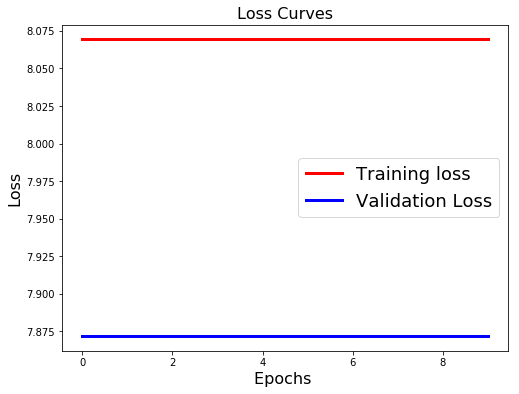

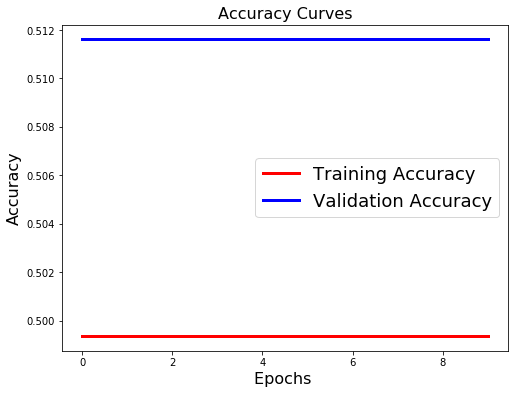

In [22]:
plot_loss_acc_curves(history)